In [1]:
from datasets import load_dataset

ds = load_dataset("kmack/Phishing_urls")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/518 [00:00<?, ?B/s]

data/train-00000-of-00001-d8afc95a165ea8(…):   0%|          | 0.00/25.4M [00:00<?, ?B/s]

data/test-00000-of-00001-4d6cbda5297196e(…):   0%|          | 0.00/3.18M [00:00<?, ?B/s]

data/valid-00000-of-00001-4e1abfe96aa382(…):   0%|          | 0.00/3.18M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/567056 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/70882 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/70882 [00:00<?, ? examples/s]

In [2]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 567056
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 70882
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 70882
    })
})

# So in label :    
# 0-> safe
# 1->malicious

In [3]:
train_df = ds["train"].to_pandas()
test_df = ds["test"].to_pandas()

In [4]:
valid_df = ds["valid"].to_pandas()

In [5]:
print(train_df.head())
print(test_df.head())
print(valid_df.head())

                                                text  label
0             xenophongroup.com/montjoie/compgns.htm      0
1    www.azzali.eu/&usg=AOvVaw2phVSb_ENMrkATGNx5LQ0l      1
2                     guildmusic.edu.au/js/index.htm      1
3  memo.unexpectedrunner.com/ezxgytw4et\nholotili...      1
4  en.wikipedia.org/wiki/Category:American_televi...      0
                                                text  label
0    www.linuxplanet.com/linuxplanet/reviews/4149/1/      1
1  sdnmargorejo1-403.sch.id/images/login.alibaba....      1
2  '9d345009-a-62cb3a1a-s-sites.googlegroups.com/...      0
3            everyculture.com/Ma-Ni/New-Zealand.html      0
4                    www.aoseocn.acseosn.selfie.ltd/      1
                                                text  label
0       absoluteastronomy.com/topics/Sri_Lankan_Navy      0
1                    www.angelfire.com/amiga/grotto/      1
2  www.etc-meisai.jp.lmxnzp.shop/kaduxn.php?lia71...      1
3  http://torcache.net/torrent/DCA42EC92

In [6]:
train_df.head()

,text,label
0,xenophongroup.com/montjoie/compgns.htm,0
1,www.azzali.eu/&usg=AOvVaw2phVSb_ENMrkATGNx5LQ0l,1
2,guildmusic.edu.au/js/index.htm,1
3,memo.unexpectedrunner.com/ezxgytw4et\nholotili...,1
4,en.wikipedia.org/wiki/Category:American_televi...,0


In [7]:
print("Shape of the training dataset is :",train_df.shape)
print("No. of missing values :",train_df.isnull().sum())
print("Duplicate values in urls:",train_df["text"].duplicated().sum())
print("Number of unique values : ",train_df.nunique())

Shape of the training dataset is : (567056, 2)
No. of missing values : text     0
label    0
dtype: int64
Duplicate values in urls: 31218
Number of unique values :  text     535838
label         2
dtype: int64


In [8]:
train_df = train_df.drop_duplicates(subset=['text'])

In [9]:
print("Duplicate values in urls:",train_df["text"].duplicated().sum())

Duplicate values in urls: 0


# FEATURE ENGINEERING

In [10]:
import pandas as pd
import re
import math
from urllib.parse import urlparse


In [11]:
import pandas as pd
import re
import math
from urllib.parse import urlparse

# --- Helper function: Shannon entropy ---
def calculate_entropy(string):
    """Measures randomness of characters in the URL."""
    if not string:
        return 0
    freq = {char: string.count(char) for char in set(string)}
    entropy = -sum((count / len(string)) * math.log2(count / len(string)) for count in freq.values())
    return entropy

# --- Main feature extraction function ---
def extract_features(url):
    features = {}
    parsed = urlparse(url)

    # 1️⃣ Basic structural features
    features['url_length'] = len(url)
    features['hostname_length'] = len(parsed.netloc)
    features['path_length'] = len(parsed.path)
    features['num_dots'] = url.count('.')
    features['num_hyphens'] = url.count('-')
    features['num_digits'] = sum(c.isdigit() for c in url)
    features['num_letters'] = sum(c.isalpha() for c in url)
    features['num_params'] = url.count('?')
    features['num_equals'] = url.count('=')
    features['num_slashes'] = url.count('/')
    features['num_at'] = url.count('@')

    # 2️⃣ Lexical / composition cues
    features['has_https'] = 1 if url.lower().startswith('https') else 0
    features['has_ip'] = 1 if re.search(r'(\d{1,3}\.){3}\d{1,3}', parsed.netloc) else 0
    features['has_subdomain'] = 1 if parsed.netloc.count('.') > 1 else 0
    features['has_suspicious_words'] = 1 if re.search(r'(login|secure|verify|update|free|bank|click)', url.lower()) else 0

    # 3️⃣ Domain / TLD features
    tld_match = re.search(r'\.([a-z]{2,})$', parsed.netloc)
    features['tld'] = tld_match.group(1) if tld_match else ''
    features['domain_length'] = len(parsed.netloc)

    # 4️⃣ Ratios
    features['digit_ratio'] = features['num_digits'] / (features['url_length'] + 1e-5)
    features['special_char_ratio'] = (features['num_hyphens'] + features['num_dots'] + features['num_slashes']) / (features['url_length'] + 1e-5)

    # 5️⃣ Entropy (measures randomness / obfuscation)
    features['url_entropy'] = calculate_entropy(url)

    # 6️⃣ Misplacement indicators
    # '@' symbol used to hide real domain (like "http://evil.com@legit.com")
    features['at_in_domain'] = 1 if '@' in parsed.netloc else 0

    # Double slashes '//' appearing after path (used to trick users)
    features['double_slash_in_path'] = 1 if re.search(r'/.+//', parsed.path) else 0

    return features


In [12]:
# Apply on your train, validation, and test sets
train_features = train_df['text'].apply(extract_features).apply(pd.Series)
valid_features = valid_df['text'].apply(extract_features).apply(pd.Series)
test_features  = test_df['text'].apply(extract_features).apply(pd.Series)

# Add the labels back
train_features['label'] = train_df['label']
valid_features['label'] = valid_df['label']
test_features['label']  = test_df['label']


In [13]:
train_features.head()

,url_length,hostname_length,path_length,num_dots,num_hyphens,num_digits,num_letters,num_params,num_equals,num_slashes,...,has_subdomain,has_suspicious_words,tld,domain_length,digit_ratio,special_char_ratio,url_entropy,at_in_domain,double_slash_in_path,label
0,38,0,38,2,0,0,34,0,0,2,...,0,0,,0,0.00000,0.105263,3.816181,0,0,0
1,47,0,47,2,0,3,38,0,1,1,...,0,0,,0,0.06383,0.063830,4.985336,0,0,1
2,30,0,30,3,0,0,25,0,0,2,...,0,0,,0,0.00000,0.166667,3.898069,0,0,1
3,92,0,92,5,0,1,82,0,0,3,...,0,0,,0,0.01087,0.086957,4.336708,0,0,1
4,56,0,56,2,0,0,49,0,0,2,...,0,0,,0,0.00000,0.071429,4.324165,0,0,0


In [14]:
train_df.dtypes

,0
text,object
label,int64


In [15]:
train_features.dtypes

,0
url_length,int64
hostname_length,int64
path_length,int64
num_dots,int64
num_hyphens,int64
num_digits,int64
num_letters,int64
num_params,int64
num_equals,int64
num_slashes,int64


In [16]:
train_features['tld'].nunique()

260

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

label                   1.000000
num_dots                0.258984
special_char_ratio      0.175742
has_suspicious_words    0.170722
has_subdomain           0.111182
hostname_length         0.093371
domain_length           0.093371
digit_ratio             0.071873
num_at                  0.068199
has_https               0.067907
dtype: float64


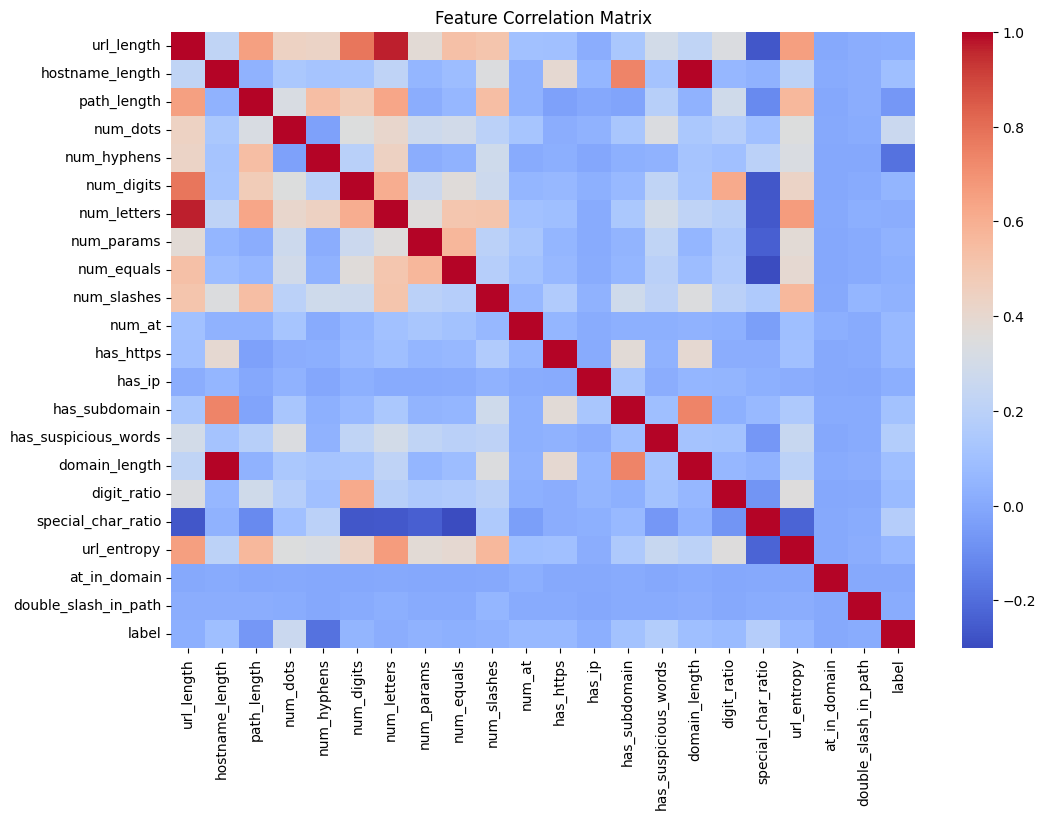

In [18]:
# Select numeric columns only (excluding label)
numeric_features = train_features.select_dtypes(include=['int64', 'float64'])
# numeric_features = numeric_features.drop('label', axis=1)

# Compute correlation of each feature with the target label
corr = numeric_features.corrwith(train_features['label'])

# Show top 10 most correlated features
print(corr.sort_values(ascending=False).head(10))

# Visualize correlation matrix (optional)
plt.figure(figsize=(12,8))
sns.heatmap(numeric_features.corr(), annot=False, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()


Fixing object type -> TLD

In [19]:
common = ['com', 'net', 'org']
country_codes = ['uk', 'in', 'us', 'de', 'fr']
suspicious_tlds = ['xyz', 'top', 'info', 'buzz', 'club']

def tld_group(tld):
    if pd.isna(tld):
        return 'unknown'
    elif tld in common:
        return 'common'
    elif tld in country_codes:
        return 'country'
    else:
        return 'rare'

train_features['TLD_group'] = train_features['tld'].apply(tld_group)
train_features['suspicious_tld'] = train_features['tld'].apply(lambda t: 1 if t in suspicious_tlds else 0)

train_features = pd.get_dummies(train_features, columns=['TLD_group'], drop_first=True)
train_features = train_features.drop(columns=['tld'])


In [20]:
test_features['TLD_group'] = test_features['tld'].apply(tld_group)
test_features['suspicious_tld'] = test_features['tld'].apply(lambda t: 1 if t in suspicious_tlds else 0)

test_features = pd.get_dummies(test_features, columns=['TLD_group'], drop_first=True)
test_features = test_features.drop(columns=['tld'])

In [21]:
valid_features['TLD_group'] = valid_features['tld'].apply(tld_group)
valid_features['suspicious_tld'] = valid_features['tld'].apply(lambda t: 1 if t in suspicious_tlds else 0)

valid_features = pd.get_dummies(valid_features, columns=['TLD_group'], drop_first=True)
valid_features = valid_features.drop(columns=['tld'])


In [22]:
train_features.dtypes

,0
url_length,int64
hostname_length,int64
path_length,int64
num_dots,int64
num_hyphens,int64
num_digits,int64
num_letters,int64
num_params,int64
num_equals,int64
num_slashes,int64


In [23]:
X_train = train_features.drop('label',axis =1)
y_train = train_features['label']

X_valid = valid_features.drop('label',axis = 1)
y_valid = valid_features['label']

X_test = test_features.drop('label',axis =1)
y_test = test_features['label']

In [24]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
model = xgb.XGBClassifier(
    n_estimators=1000,        # large number to allow early stopping
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',    # or 'auc' if binary classification
    use_label_encoder=False,
    random_state=42
)


In [26]:
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    # early_stopping_rounds=20,  # stops if validation doesn't improve for 20 rounds
    verbose=True
)


[0]	validation_0-logloss:0.66738	validation_1-logloss:0.66878
[1]	validation_0-logloss:0.64593	validation_1-logloss:0.64859


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:12:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[2]	validation_0-logloss:0.62726	validation_1-logloss:0.63118
[3]	validation_0-logloss:0.61047	validation_1-logloss:0.61546
[4]	validation_0-logloss:0.59732	validation_1-logloss:0.60328
[5]	validation_0-logloss:0.58693	validation_1-logloss:0.59370
[6]	validation_0-logloss:0.57543	validation_1-logloss:0.58302
[7]	validation_0-logloss:0.56676	validation_1-logloss:0.57499
[8]	validation_0-logloss:0.55823	validation_1-logloss:0.56718
[9]	validation_0-logloss:0.55037	validation_1-logloss:0.56000
[10]	validation_0-logloss:0.54402	validation_1-logloss:0.55435
[11]	validation_0-logloss:0.53696	validation_1-logloss:0.54796
[12]	validation_0-logloss:0.53200	validation_1-logloss:0.54344
[13]	validation_0-logloss:0.52683	validation_1-logloss:0.53870
[14]	validation_0-logloss:0.52217	validation_1-logloss:0.53449
[15]	validation_0-logloss:0.51878	validation_1-logloss:0.53143
[16]	validation_0-logloss:0.51458	validation_1-logloss:0.52782
[17]	validation_0-logloss:0.51022	validation_1-logloss:0.52389


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, ...)

Validation Accuracy: 0.7913010355238284
Test Accuracy: 0.7905956378206033


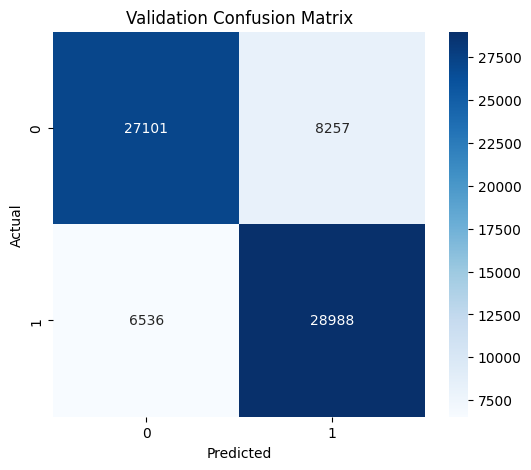

              precision    recall  f1-score   support

           0       0.80      0.76      0.78     35239
           1       0.78      0.82      0.80     35643

    accuracy                           0.79     70882
   macro avg       0.79      0.79      0.79     70882
weighted avg       0.79      0.79      0.79     70882



In [27]:
# Predict
y_pred_valid = model.predict(X_valid)
y_pred_test  = model.predict(X_test)

# Accuracy
print("Validation Accuracy:", accuracy_score(y_valid, y_pred_valid))
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))

# Confusion Matrix (Validation)
cm = confusion_matrix(y_valid, y_pred_valid)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Validation Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report (Test)
print(classification_report(y_test, y_pred_test))


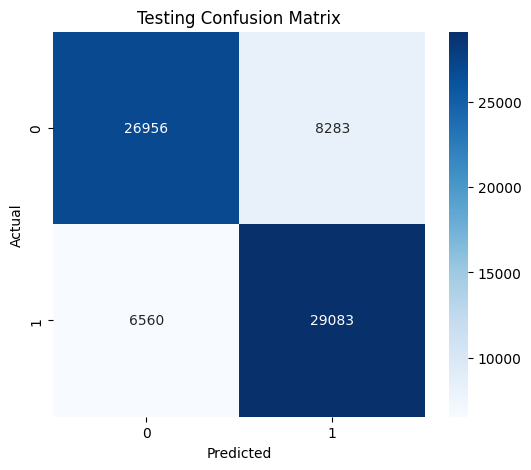

In [28]:
# Confusion Matrix (Testing)
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Testing Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

/usr/local/lib/python3.12/dist-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


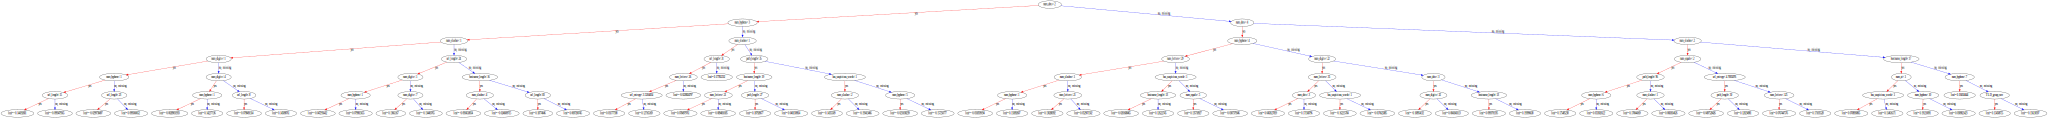

In [35]:
import xgboost as xgb

xgb.to_graphviz(model, num_trees=0)

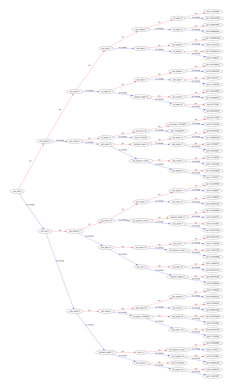

<Figure size 1200x800 with 0 Axes>

In [37]:
import matplotlib.pyplot as plt
xgb.plot_tree(model, num_trees=0, rankdir='LR')  # left-right orientation
plt.figure(figsize=(12,8))
plt.show()

In [38]:
import xgboost as xgb

# tree_idx replaces num_trees
dot = xgb.to_graphviz(model, tree_idx=0)  # first tree
dot.render("tree_small", format="png")     # saves as PNG



'tree_small.png'

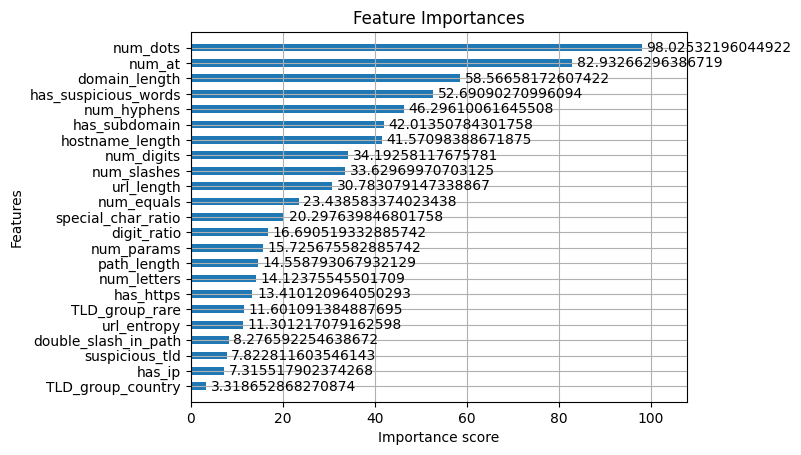

In [29]:
xgb.plot_importance(model,  importance_type='gain', height=0.5)
plt.title("Feature Importances")
plt.show()

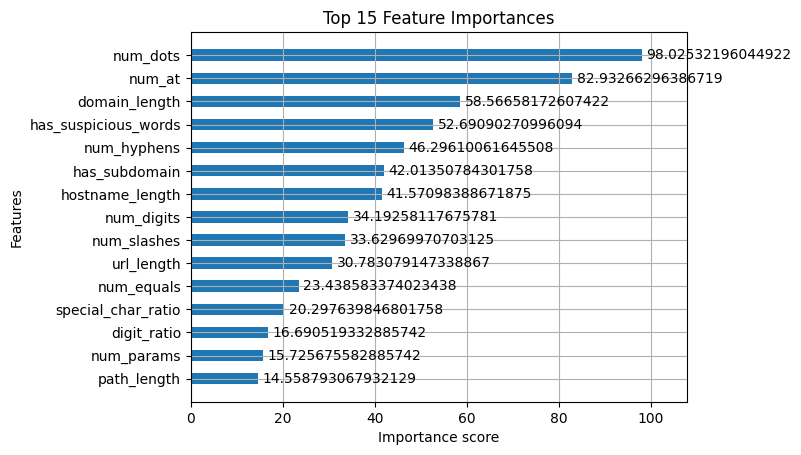

In [30]:
xgb.plot_importance(model, max_num_features=15, importance_type='gain', height=0.5)
plt.title("Top 15 Feature Importances")
plt.show()

#Working on nobilty of model :








# Dropping less important columns




In [40]:
X_train_dropped = train_features.drop(columns=['label','TLD_group_country','has_ip','suspicious_tld','double_slash_in_path','url_entropy','TLD_group_rare'],axis =1)
y_train_dropped = train_features['label']

X_valid_dropped = valid_features.drop(columns=['label','TLD_group_country','has_ip','suspicious_tld','double_slash_in_path','url_entropy','TLD_group_rare'],axis = 1)
y_valid_dropped = valid_features['label']

X_test_dropped = test_features.drop(columns=['label','TLD_group_country','has_ip','suspicious_tld','double_slash_in_path','url_entropy','TLD_group_rare'],axis =1)
y_test_dropped = test_features['label']

In [41]:
model_dropped = xgb.XGBClassifier(
    n_estimators=1000,        # large number to allow early stopping
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',    # or 'auc' if binary classification
    use_label_encoder=False,
    random_state=42
)

In [42]:
model_dropped.fit(
    X_train_dropped, y_train_dropped,
    eval_set=[(X_train_dropped, y_train_dropped), (X_valid_dropped, y_valid_dropped)],
    # early_stopping_rounds=20,  # stops if validation doesn't improve for 20 rounds
    verbose=True
)

[0]	validation_0-logloss:0.66661	validation_1-logloss:0.66804
[1]	validation_0-logloss:0.64480	validation_1-logloss:0.64754


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:41:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[2]	validation_0-logloss:0.62675	validation_1-logloss:0.63062
[3]	validation_0-logloss:0.61203	validation_1-logloss:0.61696
[4]	validation_0-logloss:0.59761	validation_1-logloss:0.60361
[5]	validation_0-logloss:0.58481	validation_1-logloss:0.59171
[6]	validation_0-logloss:0.57491	validation_1-logloss:0.58260
[7]	validation_0-logloss:0.56469	validation_1-logloss:0.57326
[8]	validation_0-logloss:0.55624	validation_1-logloss:0.56554
[9]	validation_0-logloss:0.55053	validation_1-logloss:0.56035
[10]	validation_0-logloss:0.54436	validation_1-logloss:0.55474
[11]	validation_0-logloss:0.53722	validation_1-logloss:0.54820
[12]	validation_0-logloss:0.53182	validation_1-logloss:0.54330
[13]	validation_0-logloss:0.52744	validation_1-logloss:0.53937
[14]	validation_0-logloss:0.52248	validation_1-logloss:0.53482
[15]	validation_0-logloss:0.51776	validation_1-logloss:0.53042
[16]	validation_0-logloss:0.51458	validation_1-logloss:0.52764
[17]	validation_0-logloss:0.51089	validation_1-logloss:0.52455


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, ...)

Validation Accuracy: 0.7885782003893795
Test Accuracy: 0.7874636720182839


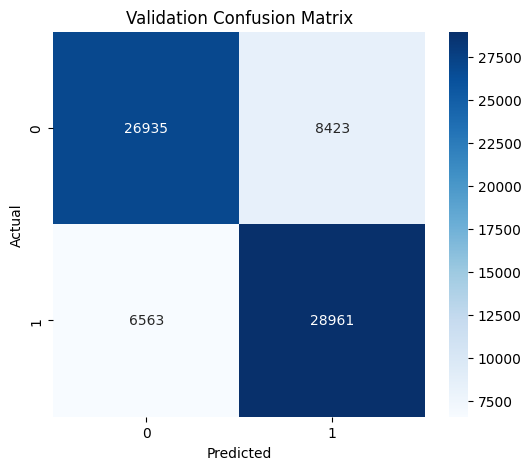

              precision    recall  f1-score   support

           0       0.80      0.76      0.78     35239
           1       0.77      0.82      0.79     35643

    accuracy                           0.79     70882
   macro avg       0.79      0.79      0.79     70882
weighted avg       0.79      0.79      0.79     70882



In [43]:
# Predict
y_pred_valid_dropped = model_dropped.predict(X_valid_dropped)
y_pred_test_dropped  = model_dropped.predict(X_test_dropped)

# Accuracy
print("Validation Accuracy:", accuracy_score(y_valid_dropped, y_pred_valid_dropped))
print("Test Accuracy:", accuracy_score(y_test_dropped, y_pred_test_dropped))

# Confusion Matrix (Validation)
cm = confusion_matrix(y_valid_dropped, y_pred_valid_dropped)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Validation Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



# Classification Report (Test)
print(classification_report(y_test_dropped, y_pred_test_dropped))

# SUMMARY: Dropping less important columns (features) didn't help............


# 2. Hyperparameter tuning

Step 1: RandomizedSearchCV — find good parameter ranges

 1: Explore hyperparameter space randomly → find promising regions.


In [45]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, f1_score, accuracy_score
import numpy as np

# Define base model
xgb_clf = XGBClassifier(
    n_estimators=500,       # use fewer trees for tuning
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

# Parameter grid to explore
param_dist = {
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.3, 0.5]
}

# Custom scorer (f1 is often better for imbalanced tasks)
scorer = make_scorer(f1_score)

# Randomized search
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=30,               # number of random combinations
    scoring=scorer,
    cv=3,                    # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train,y_train )


Fitting 3 folds for each of 30 candidates, totalling 90 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:23:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_cons...
                                           n_estimators=500, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8, 0.9,
                                                             1.0],
                                        'gamma': [0, 0.1, 0.3, 0.5],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 5, 7, 9],
                                        'min_child_weight': [1, 3, 5, 7],
                                        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]},
                   random_state=42,
                   scoring=make_scorer(f1_score, response_method='predict'),
                   verbose=2)

2: Identify the best parameter combination → know what settings maximize F1.

In [46]:
print("Best Parameters:", random_search.best_params_)
print("Best F1 Score:", random_search.best_score_)


Best Parameters: {'subsample': 1.0, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 1.0}
Best F1 Score: 0.8109496377460911


3: Evaluate on unseen validation/test → confirm generalization performance.

In [47]:
best_xgb = random_search.best_estimator_

y_pred_valid = best_xgb.predict(X_valid)
y_pred_test  = best_xgb.predict(X_test)

print("Validation Accuracy:", accuracy_score(y_valid, y_pred_valid))
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("Validation F1:", f1_score(y_valid, y_pred_valid))
print("Test F1:", f1_score(y_test, y_pred_test))


Validation Accuracy: 0.7918230298242149
Test Accuracy: 0.7898620242092492
Validation F1: 0.7972352763349548
Test F1: 0.7958778144742432


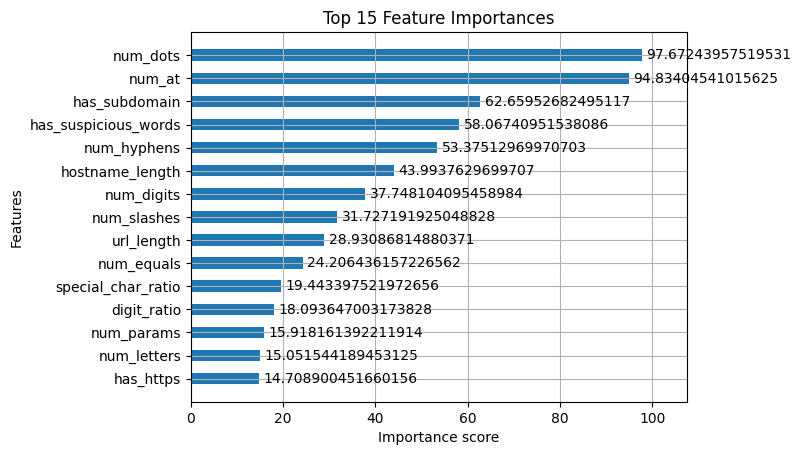

In [48]:
import matplotlib.pyplot as plt
import xgboost as xgb

xgb.plot_importance(best_xgb, max_num_features=15, importance_type='gain', height=0.5)
plt.title("Top 15 Feature Importances")
plt.show()


# SUMMARY : Hypertuning doesn't made a big difference..

hyperparameter + Dropped columns

In [50]:


# Randomized search
random_search_dropped = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=10,               # number of random combinations
    scoring=scorer,
    cv=3,                    # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search_dropped.fit(X_train_dropped,y_train_dropped )

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:48:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_cons...
                                           n_estimators=500, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8, 0.9,
                                                             1.0],
                                        'gamma': [0, 0.1, 0.3, 0.5],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 5, 7, 9],
                                        'min_child_weight': [1, 3, 5, 7],
                                        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]},
                   random_state=42,
                   scoring=make_scorer(f1_score, response_method='predict'),
                   verbose=2)

In [51]:
print("Best Parameters:", random_search_dropped.best_params_)
print("Best F1 Score:", random_search_dropped.best_score_)

Best Parameters: {'subsample': 0.6, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.6}
Best F1 Score: 0.8079695011433845


In [52]:
best_xgb_dropped = random_search_dropped.best_estimator_

y_pred_valid_dropped_hyp = best_xgb_dropped.predict(X_valid_dropped)
y_pred_test_dropped_hyp  = best_xgb_dropped.predict(X_test_dropped)

print("Validation Accuracy:", accuracy_score(y_valid_dropped, y_pred_valid_dropped_hyp))
print("Test Accuracy:", accuracy_score(y_test_dropped, y_pred_test_dropped_hyp))
print("Validation F1:", f1_score(y_valid_dropped, y_pred_valid_dropped_hyp))
print("Test F1:", f1_score(y_test_dropped, y_pred_test_dropped_hyp))


Validation Accuracy: 0.7873225924776389
Test Accuracy: 0.7862644959228012
Validation F1: 0.7933601085630474
Test F1: 0.7928516735943995
